In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
#names = ['Size', '#Threads', 'Runtime (s)', 'Energy (J)']
#df = pd.read_csv('matmul_cn128_pinned.csv', names=names, usecols=[0, 1, 3, 5])

names = ['Size', '#Threads', 'Runtime (s)', 'Energy (J)']
df = pd.read_csv('matmul_cn126_rust.csv', names=names, usecols=[0, 1, 2, 4])

flop = df['Size'] * df['Size'] * (2 * df['Size'] - 1)
df['GFLOP/s'] = flop / df['Runtime (s)'] / 1e9
df['GFLOP/J'] = flop / df['Energy (J)'] / 1e9

df

,Size,#Threads,Runtime (s),Energy (J),GFLOP/s,GFLOP/J
0,300,1,0.093171,1.372338,0.578612,0.039283
1,300,2,0.046796,0.843067,1.152024,0.063945
2,300,3,0.036491,0.753703,1.477340,0.071527
3,300,4,0.023632,0.589595,2.281206,0.091436
4,300,5,0.020664,0.556825,2.608837,0.096817
...,...,...,...,...,...,...
203,1500,12,1.841644,74.984085,3.663982,0.089989
204,1500,13,1.901435,77.358368,3.548767,0.087227
205,1500,14,1.975789,80.047714,3.415218,0.084297
206,1500,15,2.094246,84.016423,3.222042,0.080315


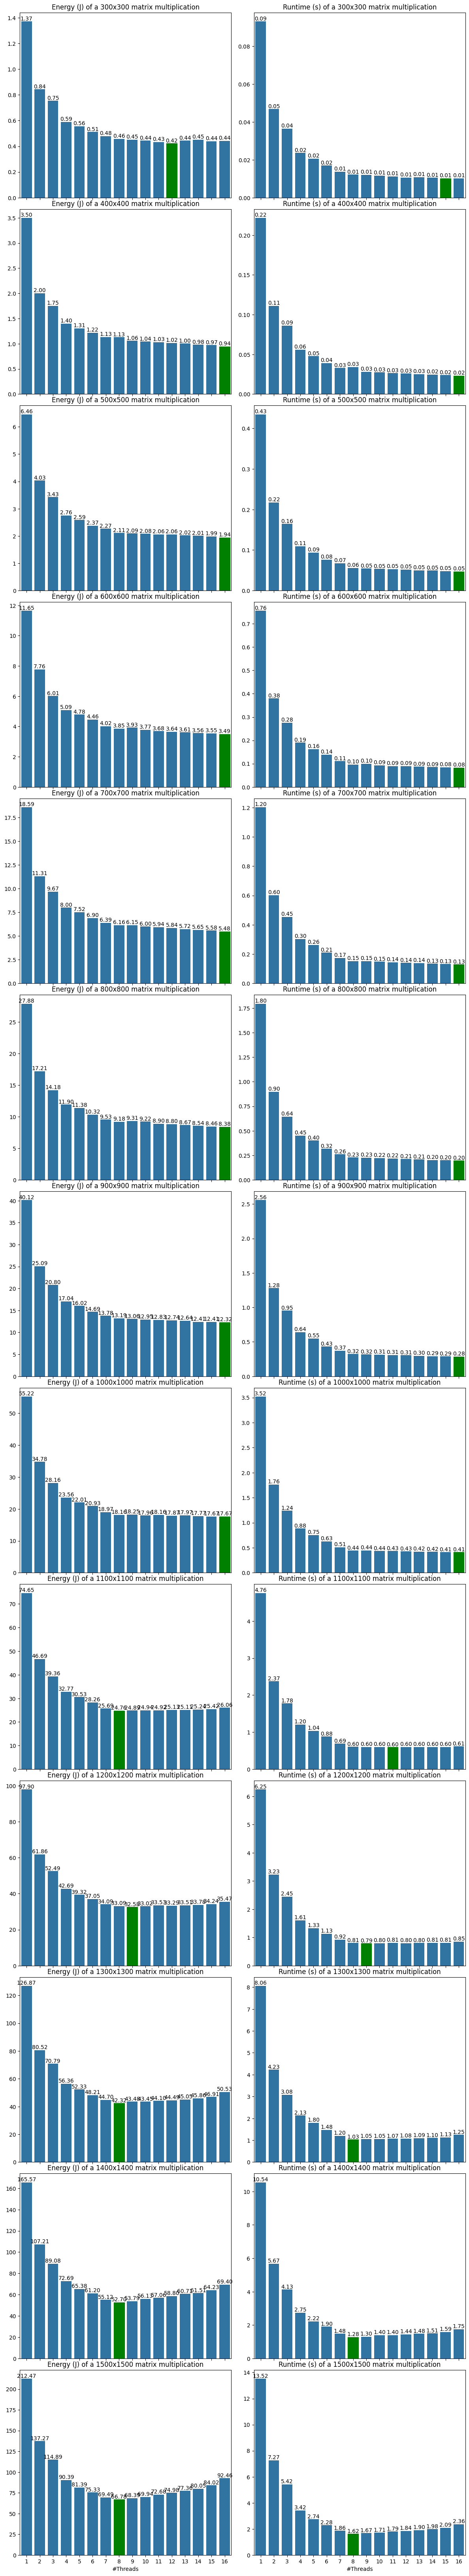

In [6]:
by_size = df.groupby('Size')

fig, axs = plt.subplots(len(by_size), 2, figsize=(12, 5 * len(by_size)), sharex=True)
fig.tight_layout()

for ((size, dfx), (ax_j, ax_s)) in zip(df.groupby('Size'), axs):
    sns.barplot(dfx, x='#Threads', y='Energy (J)', ax=ax_j)
    sns.barplot(dfx, x='#Threads', y='Runtime (s)', ax=ax_s)

    ax_j.set_title(f'Energy (J) of a {size}x{size} matrix multiplication')
    ax_s.set_title(f'Runtime (s) of a {size}x{size} matrix multiplication')
    ax_j.set_ylabel('')
    ax_s.set_ylabel('')
    
    def color_best(ax, col):
        ax.bar_label(ax.containers[0], fmt='%.2f')
        for bar in ax.patches:
            if bar.get_height() == dfx[col].min():
                bar.set_color('g')
                return
    color_best(ax_j, 'Energy (J)')
    color_best(ax_s, 'Runtime (s)')

plt.show()

In [ ]:
by_size = df.groupby('Size')

fig, axs = plt.subplots(len(by_size), 2, figsize=(12, 5 * len(by_size)), sharex=True)
fig.tight_layout()

for ((size, dfx), (ax_j, ax_s)) in zip(df.groupby('Size'), axs):
    sns.barplot(dfx, x='#Threads', y='GFLOP/J', ax=ax_j)
    sns.barplot(dfx, x='#Threads', y='GFLOP/s', ax=ax_s)

    ax_j.set_title(f'{size}x{size} matrix multiplication')
    ax_s.set_title(f'{size}x{size} matrix multiplication')
    
    def color_best(ax, col):
        for bar in ax.patches:
            if bar.get_height() == dfx[col].max():
                bar.set_color('g')
                return
    color_best(ax_j, 'GFLOP/J')
    color_best(ax_s, 'GFLOP/s')

plt.show()